In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *
from tqdm import tqdm

%matplotlib inline

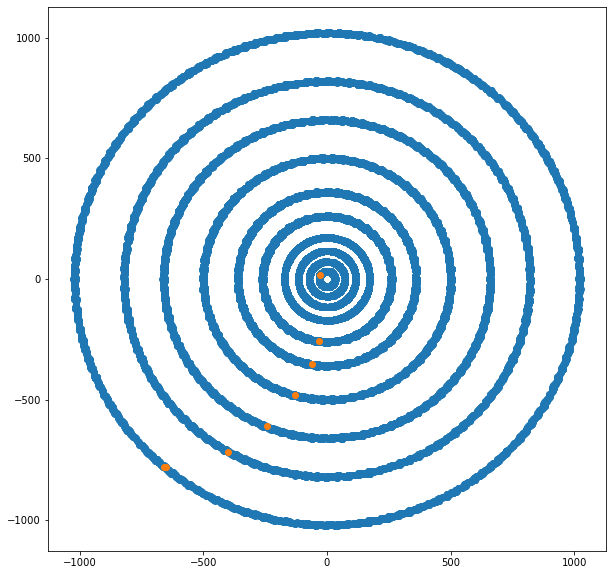

In [15]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]
trackId = selected_truth.particle_id.unique()[505]
track = selected_truth[selected_truth.particle_id == trackId]
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
ax.plot(track.tx, track.ty, 'o')
plt.show()

In [5]:
data = np.load("train_set_29144_101_and_103.npz")
train_X = data['X']
train_y = data['y']
train_y_mag = data['y_mag']
test_X = data['X_test']
test_y_mag = data['y_mag_test']
test_y = data['y_test']

In [10]:
print(train_X.shape, train_y.shape, train_y_mag.shape)
print(test_X.shape, test_y.shape, test_y_mag.shape)
B = 1000

(29144, 1000, 10, 1) (29144, 2) (29144, 1)
(9716, 1000, 10, 1) (9716, 2) (9716, 1)


In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import backend as K
from keras import regularizers
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [12]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(8, (3, 3), activation="relu", input_shape=(B, 10, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(10, activation="relu"),
        layers.Dense(1)
    ])

    #optimizer = keras.optimizers.RMSprop(learning_rate=0.00001) #0.00001 works good
    model.compile(loss='mae', optimizer="adam")
    return model

In [13]:
model = build_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 998, 8, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 499, 4, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 497, 2, 16)        1168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 15904)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                159050    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 160,309
Trainable params: 160,309
Non-trainable params: 0
_______________________________________________

In [14]:
EPOCHS = 20
print(train_X.shape)
print(train_y.shape)
history = model.fit(train_X, train_y_mag, validation_split=0.1, epochs=EPOCHS) 

(29144, 1000, 10, 1)
(29144, 2)

Train on 26229 samples, validate on 2915 samples
Epoch 1/20
26229/26229 [==============================] - 9s 331us/step - loss: 0.1462 - val_loss: 0.1156
Epoch 2/20
26229/26229 [==============================] - 8s 297us/step - loss: 0.0887 - val_loss: 0.0910
Epoch 3/20
26229/26229 [==============================] - 8s 290us/step - loss: 0.0706 - val_loss: 0.0826
Epoch 4/20
26229/26229 [==============================] - 16s 620us/step - loss: 0.0624 - val_loss: 0.0719
Epoch 5/20
26229/26229 [==============================] - 8s 290us/step - loss: 0.0582 - val_loss: 0.0724
Epoch 6/20
26229/26229 [==============================] - 8s 289us/step - loss: 0.0537 - val_loss: 0.0678
Epoch 7/20
26229/26229 [==============================] - 8s 293us/step - loss: 0.0526 - val_loss: 0.0660
Epoch 8/20
26229/26229 [==============================] - 8s 294us/step - loss: 0.0495 - val_loss: 0.0669
Epoch 9/20
26229/26229 [==============================] - 7s 271us/st

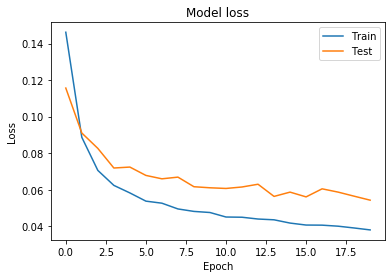

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [17]:
test_loss = model.evaluate(test_X, test_y_mag)
print(test_loss)

train_loss = model.evaluate(train_X, train_y_mag)
print(train_loss)

9716/9716 [==============================] - 1s 150us/step
0.043758680323923306
29144/29144 [==============================] - 4s 145us/step
0.03749448146068752


In [19]:
percentages = []
for i in range(len(test_X)):
    prediction = model.predict(np.reshape(test_X[i], (1, B, 10, 1)))
    percentages.append(abs((prediction - test_y_mag[i]) / test_y_mag[i]) * 100)
percentages = np.array(percentages)
print("Accuracy:", 100 - np.mean(percentages))

Accuracy: 95.0792354688647
